A two layer experiment that aims to benchmark barycenter, sifting, and median heuristic algorithms to bipartite graphs generated using NetworkX. We will be implementing benchmarking against Stanford Graphbase soon.




In [27]:
# Imports 

import sys
import os
import random
import json
import copy
import time
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations, permutations
from typing import Dict, Union, List, Set
from concurrent.futures import ProcessPoolExecutor
%load_ext cython


The cython extension is already loaded. To reload it, use:
  %reload_ext cython


## Helper Functions

These functions serves as helper functions for the algorithms and the overall code.
- count_crossings - counts crossings, needs a graph object and a pos object.
- cross_count

- draw_horizontal_bipartite - visualization function
- visualize_bipartite_graph - visualizer but with only 2 parameters: graph object and bottom nodes
- plot_results - given a data frame, shows the results in table and chart format

- generate_bipartite_graph - graph generator
- forced_density_gen_bip_graph - fixed density bipartite graph.


- parse_edges (converts format of edge lists) [{'nodes': ['u0', 'u6']}, ...] --> [(top_node, bottom_node), ...]
- update_positions

### Crossing number Functions

In [28]:
def count_crossings(B, pos):
    """
    Count the number of edge crossings in a bipartite graph layout.
    
    Args:
        B: The bipartite graph (NetworkX object).
        pos: A dictionary with node positions from a layout.
    
    Returns:
        Number of edge crossings in the graph.
    """
    crossings = 0
    edges = list(B.edges())
    # Iterate over all pairs of edges
    # print("DEBUG count_crossings function, length of edges:", len(edges))
    # print("Type of Graph:", B)
    # print("These are its combinations:", len(list(combinations(edges, 2))))
    # print("\n")
    for (u1, v1), (u2, v2) in combinations(edges, 2):
        # Get positions of the edges' endpoints
        try: 
            x1, x2 = pos[u1][0], pos[v1][0]
            x3, x4 = pos[u2][0], pos[v2][0]
        except:
            # print("DEBUG (count_crossings), edges and pos", edges, pos)
            pass
        # Check if the edges cross (intersection in x-coordinates)
        if (x1 < x3 and x2 > x4) or (x1 > x3 and x2 < x4):
            crossings += 1
    return crossings

In [29]:

def node_neighbors(target: str, edges: list, fixed_layer_nodes: List[str]) -> list[str]:
    """
    Find all neighbors of a target node in a list of edges.

    This function takes a target node and a list of edges, and returns a list
    of all nodes that are directly connected to the target node.

    Args:
        target (str): The target node label.
        edges (list): A list of edges, where each edge is represented as a dictionary
                      with a "nodes" key containing a list of two node labels.
        fixed_layer_nodes (List[str]): The nodes in the fixed layer. Will be used for limiting the scope of the neighbors of a node in the free layer.
    Returns:
        list[str]: A list of node labels that are neighbors of the target node.
    """
    
    # print("Inside node_neigbors:", target, edges, fixed_layer_nodes)
    neighbors = []
    for edge_data in edges:
        edge_node_arr = edge_data["nodes"]
        if target in edge_node_arr:
            other_node = edge_node_arr[1] if edge_node_arr[0] == target else edge_node_arr[0]
            if other_node in fixed_layer_nodes:                
                neighbors.append(other_node)
    # neighbors = [
    #     edge_node_arr[1] if edge_node_arr[0] == target else edge_node_arr[0]
    #     for edge_data in edges
    #     for edge_node_arr in [edge_data["nodes"]]
    #     if target in edge_node_arr and (edge_node_arr[1] if edge_node_arr[0] == target else edge_node_arr[0]) in fixed_layer_nodes
    # ]
    return neighbors


def u_prime_list_processor(target: str, free_layer: list) -> List[str]:
    """
    Finds all the nodes that are to the left of a target node in the same layer.
    Fills u_prime_nodes.

    Args:
        target (str): The target node label.
        pos (Dict[str, List[float]]): A dictionary containing the positional data of the nodes.
                                      The keys are node labels, and the values are lists of two floats
                                      representing the (x, y) coordinates of the nodes.
        free_layer: for now, it is an unordered list of the nodes in a layer that we are dealing with

    Returns:
        List[str]: A list of node labels that are to the left of the target node in the same layer.
    """
    # target_coords = pos[target]
    target_node_order = free_layer.index(target)
    u_prime_list = []
    if not (len(free_layer) == 1 or target_node_order == 0): u_prime_list = free_layer[:target_node_order]

    return u_prime_list

    # Trivial case where the target node is the only node in that layer is ignored
    # Case where there is nothing to the left is handled by the for loop
    # Case where there are at least 1 node to the left is handled by the for loop.
    # if len(free_layer) != 1:
    #     for node in free_layer:
    #         if node == target:
    #             continue
    #         else:
    #             # if the x-coords of node is less than the x-coords of target node, push it to u_prime_list
    #             # NOTE: coords are usually used for graph drawing, technically u can implement this using an ordered list
    #             # we have to check pos because we know that the given layers might be unordered according to how pos orders them to.
    #             ### we have no assurances, we might no longer need pos if sure na yung list is randomly ordered 
    #             if pos[node][0] < target_coords[0]:
    #                 u_prime_list.append(node)
    

def u_prime_neighbor_filter(target_u_prime: str, u_neighbor: str, edges: list, fixed_layer_nodes: List[str],) -> List[str]:
    """
    For a certain node u_prime, we filter its neighbors (list of v_primes that are in fixed layer) that satisfies v_prime > v.
    v in this case is the u_neighbor.
    
    Args:
        target_u_prime (str): The node u_prime in which we will find its neighboring nodes
        u_neighbor (str): A neighbor node of u node where the x-coords of u_prime_neighbors will be compared.
        edges (list[str]): List of edges. 
        fixed_layer_nodes (List[str]): The nodes in the fixed layer. Will be used for limiting the scope of the neighbors of a node in the free layer.
        pos (Dict[str, List[float]]): A dictionary containing the positional data of the nodes.
                                      The keys are node labels, and the values are lists of two floats
                                      representing the (x, y) coordinates of the nodes.
    
    """ 
    u_prime_neighbors = node_neighbors(target_u_prime, edges, fixed_layer_nodes)
    u_neighbor_index = fixed_layer_nodes.index(u_neighbor)
    return [
        v_prime for v_prime in u_prime_neighbors
        if fixed_layer_nodes.index(v_prime) > u_neighbor_index
    ]

def cross_count(fixed_layer: list[str], free_layer: list[str], edges: list, ) -> int:
    """
    Calculate the number of edge crossings between two layers in a bipartite graph.

    This function counts all of the crossings present in a bipartite graph. The function takes two lists of node labels representing 
    two layers of the graph and the positional data of the nodes in the Cartesian plane. U is free, L is fixed. 
    node u belongs to free_layer. node v belongs to fixed_layer.
    
    Args:        
        fixed_layer (list[str]): List of node labels in the fixed layer. e.g. ["u2", "u3", "u4"]
        free_layer (list[str]): List of node labels in the free layer. e.g. ["u2", "u3", "u4"]
        pos_data (dict): Dictionary containing the positional data of the nodes.
                         The keys are node labels, and the values are (x, y) tuples
                         representing the positions of the nodes.
        edges (list): List of edges in the graph.

    Returns:
        int: The total number of edge crossings between the two layers.
    """
    # Reference: https://studenttheses.uu.nl/bitstream/handle/20.500.12932/46720/final_Bachelor_Thesis_Mathematics.pdf?sequence=1&isAllowed=y
    crossing_total = 0
    
    fixed_layer = [f"u{node}" if isinstance(node, int) else node for node in list(fixed_layer) ]
    free_layer =  [f"u{node}" if isinstance(node, int) else node for node in list(free_layer) ]
    
    total_neighbors = 0
    for u_node in free_layer:
        neighbor_u_node = []
        # TODO: implement filling of neighbor_u_node
        neighbor_u_node = node_neighbors(u_node, edges, fixed_layer)
        total_neighbors += len(neighbor_u_node)
        # print("neighbor u  node", neighbor_u_node)
        for v_node in neighbor_u_node:
            u_prime_nodes = []
            # TODO: implement filling u_prime, list of node u that are positioned to the left of u
            u_prime_nodes = u_prime_list_processor(u_node, free_layer)
            for u_prime in u_prime_nodes:
                # TODO: implement filtering of nodes 
                result = []                
                result = u_prime_neighbor_filter(u_prime, v_node, edges, fixed_layer)
                crossing_total += len(result)

    return crossing_total

### Visualizers (Graphs and Results)

In [30]:
def draw_horizontal_bipartite(B, top_nodes, bottom_nodes, title, node_order=None):
    """
    Draws the bipartite graph with horizontal layers.
    
    Args:
        B: Bipartite graph.
        top_nodes: Nodes in the top layer (upper row).
        bottom_nodes: Nodes in the bottom layer (lower row).
        title: Title for the plot.
        node_order: Optional reordering for bottom nodes.
    """
    # Apply reordering if provided
    if node_order:
        bottom_nodes = node_order

    # Generate positions for horizontal layout
    pos = {}
    pos.update((node, (i, 0)) for i, node in enumerate(top_nodes))  # Top nodes in the upper row (y=0)
    pos.update((node, (i, -1)) for i, node in enumerate(bottom_nodes))  # Bottom nodes in the lower row (y=-1)

    # Draw the graph
    plt.figure(figsize=(10, 6))
    nx.draw(
        B,
        pos,
        with_labels=True,
        node_size=700,
        node_color=['lightblue' if node in top_nodes else 'lightgreen' for node in B.nodes()],
        edge_color="gray",
        font_size=10,
        font_color="black"
    )
    plt.title(title, fontsize=14)
    plt.show()

In [31]:
def visualize_bipartite_graph(B, bottom_nodes):
    """
    Visualize a bipartite graph with horizontal layers.
    
    Args:
        B: The bipartite graph (NetworkX object).
        bottom_nodes: The set of bottom_nodes nodes.
    """
    # Create a bipartite layout with horizontal orientation
    pos = nx.bipartite_layout(B, bottom_nodes, align="horizontal")
    #print("The pos is " + str(pos))
    #horizontal_pos = {node: (y, -x) for node, (x, y) in pos.items()}  # Flip x and y for horizontal layers

    # Draw the graph
    plt.figure(figsize=(10, 6))
    nx.draw(
        B,
        pos=pos,
        with_labels=True,
        node_size=700,
        node_color=['lightblue' if node in bottom_nodes else 'lightgreen' for node in B.nodes()],
        edge_color="gray",
        font_size=10,
        font_color="black",
    )
    plt.title("Bipartite Graph Visualization", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Calculate and display number of crossings
    crossings = count_crossings(B, pos)
    print(f"Number of edge crossings: {crossings}")


In [32]:
def plot_results(df):
    """
    Plots the experiment results.
    Each combination of n1 and n2 will have its own line for each heuristic,
    using graph density instead of edge probability on the x-axis.
    """
    # Group by n1, n2 for clarity
    for n1 in df["n1"].unique():
        for n2 in df["n2"].unique():
            subset = df[(df["n1"] == n1) & (df["n2"] == n2)]
            if not subset.empty:
                plt.figure(figsize=(10, 6))
                
                # Compute graph density: Density = p
                density = subset["density"]  # In this case, density = edge probability p
                
                # X-axis: Graph density
                x = density
                
                # Y-axis: Number of crossings
                plt.plot(x, subset["crossings_original"], label="Original Layout", marker="o")
                plt.plot(x, subset["crossings_barycenter"], label="Barycenter Heuristic", marker="s")
                plt.plot(x, subset["crossings_median"], label="Median Heuristic", marker="^")
                plt.plot(x, subset["crossings_sifting"], label="Simple Sifting Heuristic", marker="x")
                # Add labels and title
                plt.title(f"Crossings for n1 = {n1}, n2 = {n2}")
                plt.xlabel("Graph Density")
                plt.ylabel("Number of Crossings")
                plt.legend()
                plt.grid(True)
                
                # Show the plot
                plt.show()

### Graph Generators

In [33]:
def generate_bipartite_graph(n1, n2, p):
    """
    Generate a bipartite graph in the specified Python format.
    
    Args:
        n1: Number of nodes in the first layer.
        n2: Number of nodes in the second layer.
        p: Probability of edge creation.
    
    Returns:
        A tuple (nodes, edges) where:
            - nodes is a list of dictionaries with "id" and "layer".
            - edges is a list of dictionaries with "nodes" as a pair of connected node IDs.
    """
    # print("generating", end="")
    while True:
        # Create a random bipartite graph
        B = nx.bipartite.random_graph(n1, n2, p)
        
        # Check if the graph is connected
        if nx.is_connected(B):
            break  # Only proceed if the graph is connected
    
    # Separate the nodes into layers
    top_nodes, bottom_nodes = nx.algorithms.bipartite.sets(B)
    
    # Create the nodes list with layer information
    nodes = []
    for node in top_nodes:
        nodes.append({"id": f"u{node}", "depth": 0})
    for node in bottom_nodes:
        nodes.append({"id": f"u{node}", "depth": 1})
    
    # Create the edges list
    edges = []
    #print("EDGES BEH" + str(B.edges()))
    for u, v in B.edges():
        edges.append({"nodes": [f"u{u}", f"u{v}"]})
    
    return nodes, edges, B, top_nodes, bottom_nodes

In [34]:
def forced_density_gen_bip_graph(n1, n2, density):
    """
    Generate a bipartite graph with a fixed edge density.

    Args:
        n1 (int): Number of nodes in the first layer.
        n2 (int): Number of nodes in the second layer.
        density (float): Desired edge density (0 to 1).

    Returns:
        tuple: (nodes, edges, B, top_nodes, bottom_nodes)
            - nodes: List of dictionaries with "id" (prefixed "u") and "depth".
            - edges: List of dictionaries with "nodes" as a pair of "u"-prefixed IDs.
            - B: The NetworkX bipartite graph (with integer node IDs).
            - top_nodes: Set of integers (nodes in the first layer).
            - bottom_nodes: Set of integers (nodes in the second layer).
    """
    assert 0 <= density <= 1, "Density must be between 0 and 1"

    # Create an empty bipartite graph
    B = nx.Graph()

    # Define integer node IDs for the two sets
    top_nodes = set(range(1, n1 + 1))  # First layer
    bottom_nodes = set(range(n1 + 1, n1 + n2 + 1))  # Second layer

    B.add_nodes_from(top_nodes, bipartite=0)
    B.add_nodes_from(bottom_nodes, bipartite=1)

    # Compute the correct number of edges based on density
    max_edges = n1 * n2  # Maximum possible edges in a bipartite graph
    num_edges = int(density * max_edges)  # Target number of edges

    # Generate all possible edges and sample from them
    possible_edges = [(u, v) for u in top_nodes for v in bottom_nodes]
    selected_edges = random.sample(possible_edges, min(num_edges, len(possible_edges)))

    # Add selected edges to the graph
    B.add_edges_from(selected_edges)

    # Convert nodes into JSON format (with "u" prefix)
    nodes = [{"id": f"u{node}", "depth": 0 if node in top_nodes else 1} for node in B.nodes()]

    # Convert edges into JSON format (with "u" prefix)
    edges = [{"nodes": [f"u{u}", f"u{v}"]} for u, v in B.edges()]

    return nodes, edges, B, top_nodes, bottom_nodes

### Data Processors

In [35]:
def parse_edges(edges, top_nodes, bottom_nodes):
    """
    Parse edges from the given format and map them to integers corresponding to top and bottom nodes.
    Args:
        edges (list): List of edges in the format [{'nodes': ['u0', 'u6']}, ...].
        top_nodes (list): List of top-layer node IDs (e.g., [0, 1, 2]).
        bottom_nodes (list): List of bottom-layer node IDs (e.g., [3, 4, 5, 6, 7]).
    
    Returns:
        list: List of tuples representing edges as (top_node, bottom_node).
    """
    parsed_edges = []
    for edge in edges:
        u, v = edge['nodes']
        # Convert 'uX' to integer node IDs
        u_id = int(u[1:])  # Remove 'u' and convert to integer
        v_id = int(v[1:])
        if u_id in top_nodes and v_id in bottom_nodes:
            parsed_edges.append((u_id, v_id))
        elif v_id in top_nodes and u_id in bottom_nodes:
            parsed_edges.append((v_id, u_id))
    # print("DEBUG: parsed_edges internal", parsed_edges, "vs", edges, "nodes",top_nodes, bottom_nodes)
    return parsed_edges

In [36]:
def update_positions(top_nodes, bottom_nodes):
    """
    Updates the positions of nodes for visualization after applying a heuristic.

    Args:
        top_nodes (list): The reordered list of nodes in the top layer (depth = 0).
        bottom_nodes (list): The reordered list of nodes in the bottom layer (depth = 1).

    Returns:
        dict: A dictionary of node positions in the format {node: (x, y)}.
    """
    pos = {}
    # Assign positions to top-layer nodes (y = 0 for depth 0)
    for i, node in enumerate(top_nodes):
        pos[node] = (i, 0)  # Top layer -> y = 0
    # Assign positions to bottom-layer nodes (y = 1 for depth 1)
    for i, node in enumerate(bottom_nodes):
        pos[node] = (i, 1)  # Bottom layer -> y = 1
    return pos

## Implemented Heuristic Algorithms

Barycenter, median, and sifting algorithms.

In [37]:
def barycenter(bottom_nodes, top_nodes, edges):
    # Ensure top_nodes is a list
    top_nodes = list(top_nodes)

    # Create a dictionary to store the neighbors of each bottom node
    neighbors = {node: set() for node in bottom_nodes}
    for u, v in edges:
        if u in top_nodes:
            neighbors[v].add(u)
        else:
            neighbors[u].add(v)

    # Calculate barycenter values for bottom nodes
    barycenter_values = {}
    for node in bottom_nodes:
        if len(neighbors[node]) > 0:
            barycenter_values[node] = sum(top_nodes.index(n) + 1 for n in neighbors[node]) / len(neighbors[node])
        else:
            barycenter_values[node] = float('inf')  # Assign a very high value for isolated nodes

    # Sort bottom nodes based on barycenter values
    sorted_bottom_nodes = sorted(bottom_nodes, key=lambda x: barycenter_values[x])

    return sorted_bottom_nodes

In [38]:
def median(bottom_nodes, top_nodes, edges):
    """
    Reorders bottom nodes using the median heuristic.
    
    Parameters:
    - bottom_nodes: List of bottom-layer nodes.
    - top_nodes: List of top-layer nodes.
    - edges: List of tuples representing edges (top_node, bottom_node).
    
    Returns:
    - Reordered list of bottom-layer nodes.
    """
    # Ensure top_nodes is a list
    top_nodes = list(top_nodes)
    # Dictionary to store neighbors of each bottom node
    neighbors = {node: [] for node in bottom_nodes}
    
    # Populate neighbors dictionary
    for u, v in edges:
        if u in top_nodes and v in bottom_nodes:
            neighbors[v].append(top_nodes.index(u) + 1)
        elif v in top_nodes and u in bottom_nodes:
            neighbors[u].append(top_nodes.index(v) + 1)
    
    # Compute the median for each bottom node
    median_values = {}
    for node, positions in neighbors.items():
        if positions:
            sorted_positions = sorted(positions)
            n = len(sorted_positions)
            # Compute median
            if n % 2 == 1:
                median_values[node] = sorted_positions[n // 2]
            else:
                median_values[node] = (sorted_positions[n // 2 - 1] + sorted_positions[n // 2]) / 2
        else:
            median_values[node] = float('inf')  # Nodes with no neighbors go to the end
    
    # Sort bottom nodes by their median values
    sorted_bottom_nodes = sorted(bottom_nodes, key=lambda x: median_values[x])
    
    return sorted_bottom_nodes


In [39]:
def do_sifting(node_to_sift: str, current_layer_order: list, fixed_layer_nodes: list[str], edges, verbose=0) -> list:
    """
    [OLD DESCRIPTION]
    Perform the sifting algorithm for a single node to minimize edge crossings.

    This function repositions a single node within its layer to minimize the number of edge crossings
    in the graph. It iteratively moves the node to different positions and calculates the number of
    crossings, keeping track of the best position with the fewest crossings.

    Args:
        node_to_sift (str): The label of the node to be sifted.
        current_layer_order (list[str]): The current order of nodes in the free layer.
        fixed_layer_nodes (list[str]): The list of node labels in the fixed layer.
        pos (dict): Dictionary containing the positional data of the nodes.
                    The keys are node labels, and the values are (x, y) tuples
                    representing the positions of the nodes.
        edges (list): List of edges in the graph.
        verbose (int, optional): Verbosity level for debugging output. Defaults to 0.

    Returns:
        dict: A dictionary containing the revised layer order and the revised positional data.
              The keys are:
                - "revised_lay_ord": The revised order of nodes in the free layer.
                - "revised_pos": The revised positional data of the nodes.
    """
    
    # have the best position, best crossing, and best layer order be saved.
    best_position = current_layer_order.index(node_to_sift) # best position initialized to current position
    min_crossing = cross_count(fixed_layer_nodes, current_layer_order, edges) # init minimum crossings
    best_layer_ord = current_layer_order
    
    # best_pos_copy = copy.deepcopy(pos) # pos must be copied so that it can be altered in a way that will improve
    
    if verbose:
        print(f"LOG: (INIT) do sifting; current node to be sifted: {node_to_sift}")
        print(f"LOG: (INIT) Inside do_sifting: best_position {best_position}, min crossing {min_crossing}, bestlayerord {best_layer_ord}")
    
    # place the node to the leftmost position, adjust pos_copy
    curr_lay_ord = current_layer_order[:best_position] + current_layer_order[best_position + 1: ] + [current_layer_order[best_position]]
    if verbose: 
        print(f"LOG-do_sifting-before sifting loop occurs curr_lay_ord, node should be at rightmost {curr_lay_ord}")
        
    curr_crossing = float('inf') # set current crossing to very high number
    if verbose: 
        print(f"LOG: (INTRO) showing the graph of {curr_lay_ord}")
    # curr_pos_copy = adjust_pos_data(current_layer_order, curr_lay_ord, pos) # we adjust the graph coord data accdg to this new arrangement
    
    # move the node to the leftmost while checking crossings and orderings
    for i in range(len(current_layer_order) - 1, -1, -1):
        curr_position = i
        if verbose: 
            print(f"Curr position value {i}, free layer order to be checked: {curr_lay_ord}")
            
        curr_crossing = cross_count(fixed_layer_nodes, curr_lay_ord, edges)
        
        if verbose: 
            print(f"LOG: do_sifting - current crossing is {curr_crossing}")
            
        if curr_crossing < min_crossing:
            best_position = curr_position
            best_layer_ord = curr_lay_ord   
            min_crossing = curr_crossing  
            # best_pos_copy = curr_pos_copy ## watch out for deepcopying
            
            if verbose: 
                print(f"\033[32mThere was an update: best_position {best_position}, best_lay_ord {best_layer_ord}, min_xsing {min_crossing}\033[30m")
                
            # how should we handle ties for different configurations?
            # TODO: handle ties, soon: CURRENT IMPLEMENTATION: crossings and best positions are not updated if curr_crossing is the same or greater.
        else:
            pass
        
        # prev_lay_ord = copy.deepcopy(curr_lay_ord)
        
        if (i != 0): 
            curr_lay_ord = curr_lay_ord[: curr_position - 1] + [curr_lay_ord[curr_position]] + [curr_lay_ord[curr_position - 1]] + curr_lay_ord[curr_position + 1:]   
        else: 
            pass # do nothing to curr_lay_ord. 
        
        if verbose:        
            print(f"LOG: inside do_sifting for loop; revised curr_lay_ord {curr_lay_ord} ")
            print(f"LOG: showing the graph of revised {curr_lay_ord}")
       
        # curr_pos_copy = adjust_pos_data(prev_lay_ord, curr_lay_ord, curr_pos_copy)
        
    
    if verbose: 
        print(f"\033[35mLOG: best_layer_ord of this run: {best_layer_ord}\n\033[30m")
    
    return {"revised_lay_ord" : best_layer_ord,}

def sifting_2(free_layer: list[str], fixed_layer: list[str], edges: list, verbose=0,) -> list:
    """
    [OLD DESCRIPTION]
    Perform the sifting algorithm to reorder the free layer nodes to minimize edge crossings.

    This function reorders the nodes in the free layer based on their indegree and positional data
    to minimize the number of edge crossings in the graph. The output is the new graph positioning
    and the reordered free layer.

    Args:
        free_layer (list[str]): List of node labels in the free layer. The "bottom nodes".
        fixed_layer (list[str]): List of node labels in the fixed layer.
        edges (list): List of edges in the graph.
        pos (dict): Dictionary containing the positional data of the nodes.
                    The keys are node labels, and the values are (x, y) tuples
                    representing the positions of the nodes.
        verbose (int, optional): Verbosity level for debugging output. Defaults to 0.
        
    Returns:
        list: A list of reordered free layer nodes <new implementation>
    """   
        # dict: A dictionary containing the new graph positioning and the reordered free layer.
        #       The keys are:
        #         - "sifting_layer_ord": The reordered free layer node labels.
        #         - "sifting_pos": The new positional data of the nodes.
    
    
    
    # Make a PRIORITY QUEUE for nodes in descending order of their indegrees.
    ## element format (node, indegree)    
    
    indeg_prio_queue = []
    
    for node in free_layer:
        indeg_cnt = len(node_neighbors(node, edges, fixed_layer))
        indeg_prio_queue.append((node, indeg_cnt))
        
    sorted_indeg_prio_queue = [item for item, _ in sorted(indeg_prio_queue, key=lambda x: x[1], reverse=True)] # ditching the indegree values after the sorting has been done
    if verbose: print("sorted_indeg_prio_queue", sorted_indeg_prio_queue)
    
    current_layer_order = free_layer[:] # assumed that free_layer order is already ordered in a sense.
    
    for node in sorted_indeg_prio_queue:
        if verbose:
            print(f"-----------New Run with the node to be sifted: {node} ---------")
            print(f"This is the current layer order func-sifting: {current_layer_order}")
        result = do_sifting(node, current_layer_order, fixed_layer, edges, verbose=verbose)
        current_layer_order = result["revised_lay_ord"]
        
    if verbose:
        print("---------------------------")
        print(f"FINAL CURRENT LAYER ORDER {current_layer_order}")
    
    # return new graph coords and the new order 
    # return {"sifting_layer_ord": current_layer_order,}
    return current_layer_order


def sifting_inactivated(free_layer: Union[Set[str], List[str]], fixed_layer: Union[Set[str], List[str]], edges: list, verbose=0,) -> list:
    """
    Perform the sifting algorithm to reorder the free layer nodes to minimize edge crossings.

    Args:
        free_layer (Union[Set[str], List[str]]): Set or list of node labels in the free layer.
        fixed_layer (Union[Set[str], List[str]]): Set or list of node labels in the fixed layer.
        edges (list): List of edges in the graph.
        verbose (int, optional): Verbosity level for debugging output. Defaults to 0.
        generated (int, optional): 0 if from the RomeLibDataset, 1 if from a generated bipartite graph made by LA. This will make the function handle things differently.

    Returns:
        list: A list of reordered free layer nodes.
    """
    # wrapper para compatible haha 
    
    fixed_layer = [f"u{node}" if isinstance(node, int) else node for node in list(fixed_layer) ]
    free_layer =  [f"u{node}" if isinstance(node, int) else node for node in list(free_layer) ]   
    
    reordered_layer = sifting_2(free_layer, fixed_layer, edges, verbose)
    
    try: 
        reordered_layer = [int(node[1:]) if isinstance(node, str) and node.startswith('u') and node[1:].isdigit() else node for node in reordered_layer]    
    except:
        print("ERROR: fixed layer =>", fixed_layer)
        print("ERROR: free layer =>", free_layer)
        
        print("ERROR: Reordered layer =>", reordered_layer)
    return reordered_layer


def sifting(bottom_nodes, top_nodes, edges, verbose=0):
    """
    Reorders bottom nodes using the sifting heuristic based on indegree in decreasing order.
    
    Parameters:
    - bottom_nodes: List of bottom-layer nodes.
    - top_nodes: List of top-layer nodes.
    - edges: List of dictionaries representing edges with format {'nodes': ['uX', 'uY']}.
    
    Returns:
    - Reordered list of bottom-layer nodes as integers.
    """
    
    top_nodes = [f"u{node}" if isinstance(node, int) else node for node in list(top_nodes) ]
    bottom_nodes = [f"u{node}" if isinstance(node, int) else node for node in list(bottom_nodes) ]  
    
    # Compute indegree for each bottom node
    indegree = {node: 0 for node in bottom_nodes}
    for edge in edges:
        _, b = edge['nodes']
        indegree[b] += 1
    
    # Sort bottom nodes by indegree in decreasing order (priority queue for processing order)
    sorted_nodes = sorted(bottom_nodes, key=lambda node: -indegree[node])
    
    # Apply the sifting heuristic
    for node in sorted_nodes:
        best_position = bottom_nodes.index(node)
        best_crossings = cross_count(top_nodes, bottom_nodes, edges)
        
        for j in range(len(bottom_nodes)):
            if bottom_nodes[j] == node:
                continue
            
            # Swap node to new position
            bottom_nodes.remove(node)
            bottom_nodes.insert(j, node)
            current_crossings = cross_count(top_nodes, bottom_nodes, edges)
            
            if current_crossings < best_crossings:
                best_position = j
                best_crossings = current_crossings
            
            # Revert swap
            bottom_nodes.remove(node)
            bottom_nodes.insert(best_position, node)
    
    # Extract integer values from node labels
    return [int(node[1:]) if isinstance(node, str) and node.startswith('u') and node[1:].isdigit() else node for node in bottom_nodes]

## Experiment Proper Sparse Graphs with |V1| = |V2|; |E| = |V1| + |V2| 

### Description
Corresponds to Experiment 1. SPARSE GRAPHS WITH AN INCREASING NUMBER OF VERTICES.

The experiment for sparse graphs with |E| = |V1| + |V2| and |V1|=|V2|. Increasing number of vertices, no relative data with the optimal solution. 10 samples each.

As of 3/8/25:
Testing for max 30 vertices only, with the 'optimal' solution.

### [IGNORE] Multiprocessing debugging,  
Multi-processing works in ipynb when the function that is going to be run per process is only called from a separate file. 

This is the source: https://stackoverflow.com/questions/62488423/brokenprocesspool-while-running-code-in-jupyter-notebook


Degrees are: {1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 1, 8: 2, 9: 2, 10: 2, 11: 3, 12: 2}
📊 Degree Analysis:
   - Average Degree: 2.00 (Expected: ≈2)
   - Max Degree: 3
   - Min Degree: 1
   - Edge Density: 0.1818
❌ Graph has 2 connected components.
Currently has 6 vertices [{'nodes': ['u1', 'u12']}, {'nodes': ['u3', 'u8']}, {'nodes': ['u5', 'u12']}, {'nodes': ['u5', 'u11']}, {'nodes': ['u2', 'u10']}, {'nodes': ['u1', 'u8']}, {'nodes': ['u2', 'u9']}, {'nodes': ['u6', 'u10']}, {'nodes': ['u4', 'u11']}, {'nodes': ['u6', 'u9']}, {'nodes': ['u4', 'u7']}, {'nodes': ['u3', 'u11']}]
Degrees are: {1: 3, 2: 2, 3: 1, 4: 1, 5: 3, 6: 2, 7: 2, 8: 3, 9: 1, 10: 2, 11: 2, 12: 2}
📊 Degree Analysis:
   - Average Degree: 2.00 (Expected: ≈2)
   - Max Degree: 3
   - Min Degree: 1
   - Edge Density: 0.1818
❌ Graph has 2 connected components.
Currently has 6 vertices [{'nodes': ['u5', 'u11']}, {'nodes': ['u1', 'u11']}, {'nodes': ['u4', 'u9']}, {'nodes': ['u6', 'u8']}, {'nodes': ['u2', 'u10']}, {'nodes': ['u1'

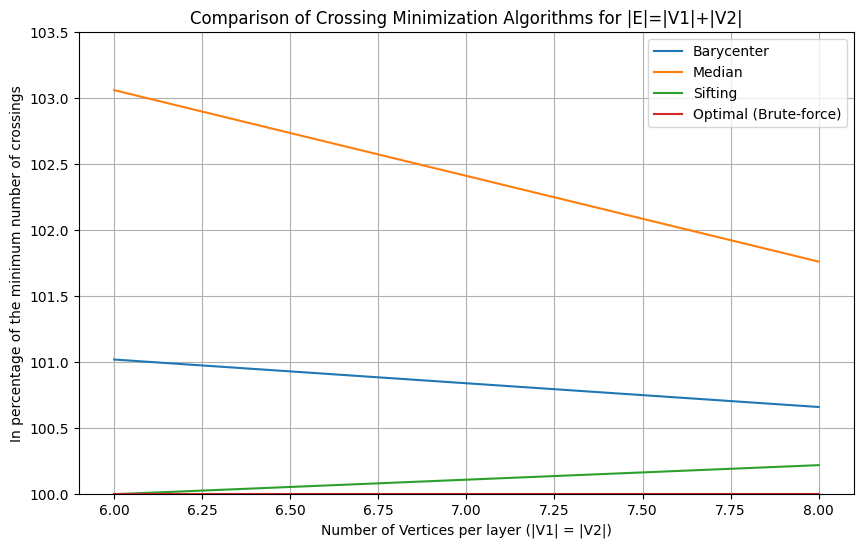

In [49]:
# Parameters for experimentation
import exp1_v1_v2_sparse_helper 

# vertex_counts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Example vertex counts for testing
# vertex_counts = [10, 20, 30,]  # Example vertex counts for testing muna, non-paper.
vertex_counts = [6, 8]
num_samples = 20 # Number of samples per vertex count


 
if __name__ == '__main__':
    start_time = time.time()

    all_results = []

    # with ProcessPoolExecutor() as executor:
    #     futures = [executor.submit(exp1_v1_v2_sparse_helper.run_experiment, n, n, num_samples) for n in vertex_counts]

    #     for future in futures:
    #         all_results.append(future.result())

    all_results = [exp1_v1_v2_sparse_helper.run_experiment(n, n, num_samples) for n in vertex_counts]


    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total execution time: {total_time:.2f} seconds")

    # Convert results to a DataFrame for analysis
    df = pd.DataFrame(all_results)

    # Display results
    print(df.to_string(index=False))

    # Save the results to a CSV file
    df.to_csv('exp1_results.csv', index=False)
    print("Results saved to 'exp1_results.csv'.")

     # Plot results
    plt.figure(figsize=(10, 6))

    # Compute y-values
    y_barycenter = df["avg_crossings_barycenter"] / df["avg_crossings_optimal"] * 100
    y_median = df["avg_crossings_median"] / df["avg_crossings_optimal"] * 100
    y_sifting = df["avg_crossings_sifting"] / df["avg_crossings_optimal"] * 100
    y_optimal = df["avg_crossings_optimal"] / df["avg_crossings_optimal"] * 100

    # Find min and max y-values
    y_min = min(y_barycenter.min(), y_median.min(), y_sifting.min(), y_optimal.min())
    y_max = max(y_barycenter.max(), y_median.max(), y_sifting.max(), y_optimal.max())

    # Round min/max to nearest 0.5
    y_min = np.floor(y_min * 2) / 2
    y_max = np.ceil(y_max * 2) / 2

    # Ensure there is at least a 0.5 difference
    if y_max - y_min < 0.5:
        y_max = y_min + 0.5

    # Set y-axis ticks with 0.5 increments
    plt.yticks(np.arange(y_min, y_max + 0.5, 0.5))

    # Plot each method
    plt.plot(df["n1"], y_barycenter, label="Barycenter")
    plt.plot(df["n1"], y_median, label="Median")
    plt.plot(df["n1"], y_sifting, label="Sifting")
    plt.plot(df["n1"], y_optimal, label="Optimal (Brute-force)")

    plt.xlabel("Number of Vertices per layer (|V1| = |V2|)")
    plt.ylabel("In percentage of the minimum number of crossings")
    plt.title("Comparison of Crossing Minimization Algorithms for |E|=|V1|+|V2|")
    plt.legend()
    plt.grid(True)

    # Apply the updated y-axis limits
    plt.ylim(y_min, y_max)

    # Save & Show plot
    plt.savefig("crossing_minimization_results.png")
    plt.show()